In [1]:
import os
import torch
from torchvision import transforms
import requests
# from transformers import MobileViTFeatureExtractor, MobileViTForSemanticSegmentation
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/home/eunjin/miniconda3/envs/deit/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# model_name = 'Matthijs/deeplabv3-mobilevit-small'
# feature_extractor = MobileViTFeatureExtractor.from_pretrained(model_name)
# model = MobileViTForSemanticSegmentation.from_pretrained(model_name)

processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-cityscapes-semantic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-cityscapes-semantic")
model.eval()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/home/eunjin/miniconda3/envs/deit/lib/python3.9/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


Mask2FormerForUniversalSegmentation(
  (model): Mask2FormerModel(
    (pixel_level_module): Mask2FormerPixelLevelModule(
      (encoder): SwinBackbone(
        (embeddings): SwinEmbeddings(
          (patch_embeddings): SwinPatchEmbeddings(
            (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
          )
          (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): SwinEncoder(
          (layers): ModuleList(
            (0): SwinStage(
              (blocks): ModuleList(
                (0): SwinLayer(
                  (layernorm_before): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
                  (attention): SwinAttention(
                    (self): SwinSelfAttention(
                      (query): Linear(in_features=192, out_features=192, bias=True)
                      (key): Linear(in_features=192, out_features=192, bias=True)
                      (valu

In [3]:
# mapogu / bundanggu
image_directory = 'data/bundanggu'
image_files = [os.path.join(image_directory, f) for f in os.listdir(image_directory) if f.endswith('.jpg')]

# ADE20K_CLASSES = [
#     'background', 'wall', 'building', 'sky', 'floor', 'tree', 'ceiling', 'road', 'bed', 'windowpane',
#     'grass', 'cabinet', 'sidewalk', 'person', 'earth', 'door', 'table', 'mountain', 'plant', 'curtain',
#     'chair', 'car', 'water', 'painting', 'sofa', 'shelf', 'house', 'sea', 'mirror', 'rug',
#     'field', 'armchair', 'seat', 'fence', 'desk', 'rock', 'wardrobe', 'lamp', 'bathtub', 'railing',
#     'cushion', 'base', 'box', 'column', 'signboard', 'chest of drawers', 'counter', 'sand', 'sink', 'skyscraper',
#     'fireplace', 'refrigerator', 'grandstand', 'path', 'stairs', 'runway', 'case', 'pool table', 'pillow', 'screen door',
#     'stairway', 'river', 'bridge', 'bookcase', 'blind', 'coffee table', 'toilet', 'flower', 'book', 'hill',
#     'bench', 'countertop', 'stove', 'palm', 'kitchen island', 'computer', 'swivel chair', 'boat', 'bar', 'arcade machine',
#     'hovel', 'bus', 'towel', 'light', 'truck', 'tower', 'chandelier', 'awning', 'streetlight', 'booth',
#     'television', 'airplane', 'dirt track', 'apparel', 'pole', 'land', 'bannister', 'escalator', 'ottoman', 'bottle',
#     'buffet', 'poster', 'stage', 'van', 'ship', 'fountain', 'conveyer belt', 'canopy', 'washer', 'plaything',
#     'swimming pool', 'stool', 'barrel', 'basket', 'waterfall', 'tent', 'bag', 'minibike', 'cradle', 'oven',
#     'ball', 'food', 'step', 'tank', 'trade name', 'microwave', 'pot', 'animal', 'bicycle', 'lake',
#     'dishwasher', 'screen', 'blanket', 'sculpture', 'hood', 'sconce', 'vase', 'traffic light', 'tray', 'ashcan',
#     'fan', 'pier', 'crt screen', 'plate', 'monitor', 'bulletin board', 'shower', 'radiator', 'glass', 'clock',
#     'flag'
# ]
CITYSCAPES_CLASSES = [
    "road", "sidewalk", "building", "wall", "fence", "pole", "traffic light", "traffic sign", "vegetation",
    "terrain", "sky", "person", "rider", "car", "truck", "bus", "train", "motorcycle", "bicycle"
]

"""
risk indicators = car, truck, bus, train, motorcycle, traffic light, road width
safety indicators = sidewalk, fence, pole, person, bicycle
"""

'\nrisk indicators = car, truck, bus, train, motorcycle, traffic light, road width\nsafety indicators = sidewalk, fence, pole, person, bicycle\n'

In [6]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

results = []

for img_path in tqdm(image_files, desc="Processing images"):
    try:
        # Load image
        image = Image.open(img_path).convert("RGB")
        
        # Preprocess
        inputs = processor(images=image, return_tensors="pt").to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)

        # Get predicted segmentation map
        segmentation = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
        predicted_mask = segmentation.cpu().numpy()

        # Compute class proportions
        total_pixels = predicted_mask.size
        class_counts = np.bincount(predicted_mask.ravel(), minlength=len(CITYSCAPES_CLASSES))
        class_proportions = class_counts / total_pixels

        # Store results
        result = {
            'Image File': os.path.basename(img_path)
        }
        result.update({CITYSCAPES_CLASSES[i]: round(class_proportions[i], 4) for i in range(len(CITYSCAPES_CLASSES))})
        results.append(result)

    except Exception as e:
        print(f"Error processing {img_path}: {e}")

# Save results
df = pd.DataFrame(results)
df.to_csv("segmentation_results_cityscapes_bundanggu.csv", index=False)

Processing images: 100%|██████████| 1552/1552 [01:22<00:00, 18.73it/s]


### Calculate the Bicycle Safety Score (BSS)

In [7]:
safe_classes = ['sidewalk', 'fence', 'pole', 'person', 'bicycle']
risk_classes = ['car', 'truck', 'bus', 'train', 'motorcycle', 'traffic light', 'road']

# Load the CSV
df = pd.read_csv("segmentation_results_cityscapes_bundanggu.csv")

# Rename columns if needed (ensure first column is image filename)
df.columns = ['Image File'] + CITYSCAPES_CLASSES

# Compute BSS
df['SafeScore'] = df[safe_classes].sum(axis=1)
df['RiskScore'] = df[risk_classes].sum(axis=1)

# Add small epsilon to avoid division by zero
epsilon = 1e-6
df['BSS'] = df['SafeScore'] / (df['RiskScore'] + epsilon)

# Save to CSV
df.to_csv("segmentation_results_with_bss_bundanggu.csv", index=False)

# Optional: Show top 10 safest and riskiest images
print("Top 10 safest locations:")
print(df.sort_values(by='BSS', ascending=False)[['Image File', 'BSS']].head(10))

print("\nTop 10 riskiest locations:")
print(df.sort_values(by='BSS')[['Image File', 'BSS']].head(10))

Top 10 safest locations:
                                         Image File          BSS
1338    37.37243212821557_127.1045819724932_0_0.jpg  1058.882236
322     37.35972832249805_127.1275054824637_0_0.jpg   102.365878
1418     37.35972797816354_127.127505073468_0_0.jpg    59.229772
975    37.35972797816354_127.127505073468_1_180.jpg    59.229772
889    37.3598716983337_127.1268055237315_1_180.jpg    22.452470
717     37.35992885704765_127.1124413356042_0_0.jpg    15.434855
1063    37.36098161362321_127.1165346476139_0_0.jpg     6.389357
270   37.36098161362321_127.1165346476139_1_180.jpg     6.389357
1093    37.36852306512863_127.1073683083024_0_0.jpg     6.075253
470    37.3668549008044_127.1164623261547_1_180.jpg     3.055605

Top 10 riskiest locations:
                                        Image File  BSS
432    37.37080216068905_127.1139559011328_0_0.jpg  0.0
199   37.3666722165459_127.1121197972476_1_180.jpg  0.0
194    37.36104398121453_127.1223111314884_0_0.jpg  0.0
336    3

### Add lat(x) and lng(y) fields

In [11]:
# Load the existing CSV
input_csv = "segmentation_results_with_bss_mapogu.csv"
df = pd.read_csv(input_csv)

# Parse lat/lng from filename
def extract_lat_lng(filename):
    try:
        parts = filename.split('_')
        lat = float(parts[0])
        lng = float(parts[1])
        return lng, lat  # x = lng, y = lat
    except (IndexError, ValueError):
        return None, None

# Apply the parsing
df[['x', 'y']] = df['Image File'].apply(lambda f: pd.Series(extract_lat_lng(f)))

# Save the updated CSV
output_csv = "segmentation_results_with_bss_mapogu_with_xy.csv"
df.to_csv(output_csv, index=False)

print(f"Updated CSV with coordinates saved to: {output_csv}")


Updated CSV with coordinates saved to: segmentation_results_with_bss_mapogu_with_xy.csv


<Figure size 1000x600 with 0 Axes>

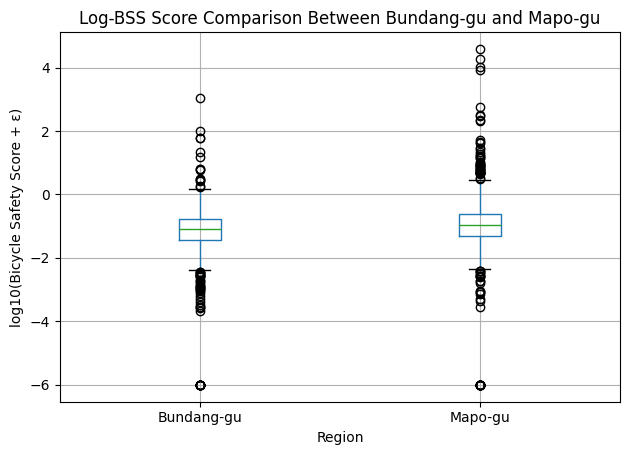

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load corrected file paths (please adjust if necessary)
bundanggu_df = pd.read_csv("segmentation_results_with_bss_bundanggu_with_xy.csv")
mapogu_df = pd.read_csv("segmentation_results_with_bss_mapogu_with_xy.csv")

# Add region labels
bundanggu_df['Region'] = 'Bundang-gu'
mapogu_df['Region'] = 'Mapo-gu'

# Combine the two dataframes
combined_df = pd.concat([bundanggu_df, mapogu_df], ignore_index=True)

# Add log-transformed BSS column
epsilon = 1e-6  # to avoid log(0)
combined_df['log_BSS'] = np.log10(combined_df['BSS'] + epsilon)

# Boxplot comparison of log(BSS) scores
plt.figure(figsize=(10, 6))
combined_df.boxplot(column='log_BSS', by='Region')
plt.title('Log-BSS Score Comparison Between Bundang-gu and Mapo-gu')
plt.suptitle('')
plt.ylabel('log10(Bicycle Safety Score + ε)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
import pandas as pd
import numpy as np

# Load your CSVs
bundanggu_df = pd.read_csv("segmentation_results_with_bss_bundanggu_with_xy.csv")
mapogu_df = pd.read_csv("segmentation_results_with_bss_mapogu_with_xy.csv")

# Compute mean and median
mean_bss_bundanggu = bundanggu_df['BSS'].mean()
mean_bss_mapogu = mapogu_df['BSS'].mean()
median_bss_bundanggu = bundanggu_df['BSS'].median()
median_bss_mapogu = mapogu_df['BSS'].median()

# Optional: log-BSS
log_bss_bundanggu = np.log10(bundanggu_df['BSS'] + 1e-6).mean()
log_bss_mapogu = np.log10(mapogu_df['BSS'] + 1e-6).mean()

print(f"Bundang-gu: mean BSS = {mean_bss_bundanggu:.2f}, median BSS = {median_bss_bundanggu:.2f}")
print(f"Mapo-gu: mean BSS = {mean_bss_mapogu:.2f}, median BSS = {median_bss_mapogu:.2f}")
print(f"Log-BSS (mean): Bundang-gu = {log_bss_bundanggu:.2f}, Mapo-gu = {log_bss_mapogu:.2f}")


Bundang-gu: mean BSS = 1.00, median BSS = 0.08
Mapo-gu: mean BSS = 49.90, median BSS = 0.11
Log-BSS (mean): Bundang-gu = -1.15, Mapo-gu = -0.99
